In [48]:
import pandas as pd
from transformers import T5Config, T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer, GenerationConfig, TFT5ForConditionalGeneration
import tensorflow as tf
from typing import Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
splits = {'test': 'all/test-00000-of-00001.parquet', 'train': 'all/train-00000-of-00001.parquet', 'validation': 'all/validation-00000-of-00001.parquet'}
df_test = pd.read_parquet("hf://datasets/ehovy/race/" + splits["test"])
df_train = pd.read_parquet("hf://datasets/ehovy/race/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/ehovy/race/" + splits["validation"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df_train[:5]

,example_id,article,answer,question,options
0,high19088.txt,Last week I talked with some of my students ab...,C,We can know from the passage that the author w...,"[doctor, model, teacher, reporter]"
1,high19088.txt,Last week I talked with some of my students ab...,C,Many graduates today turn to cosmetic surgery ...,"[marry a better man/woman, become a model, get..."
2,high19088.txt,Last week I talked with some of my students ab...,D,"According to the passage, the author believes ...","[everyone should purchase perfection, whatever..."
3,high19088.txt,Last week I talked with some of my students ab...,B,Which' s the best title for the passage?.,"[Young Graduates Have Higher Expectations, You..."
4,high15596.txt,"YUZHOU, HENAN -An accident in a central China ...",B,What could be the best title for this passage?,"[Death Toll Rises in an Accident in China, A C..."


In [4]:
tokenizer = AutoTokenizer.from_pretrained('t5-small')

In [5]:
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [6]:
MAX_LENGTH = 512
PAD_MASK = -100

In [7]:
def preprocess_function(data):
    match data.loc['answer']:
      case 'A':
          data.loc['answer'] = 0
      case 'B':
          data.loc['answer'] = 1
      case 'C':
          data.loc['answer'] = 2
      case 'D':
          data.loc['answer'] = 3

    input_text = f"Generate multiple choice question: {data.loc['article']}"
    output_text = f"Q: {data.loc['question']} A: (a) {data.loc['options'][0]} (b) {data.loc['options'][1]} (c) {data.loc['options'][2]} (d) {data.loc['options'][3]}\n Ans: {data.loc['answer']}"

    input_encoding = tokenizer(
        input_text, max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="tf"
    )
    output_encoding = tokenizer(
        output_text, max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="tf"
    )

    input_ids = input_encoding["input_ids"]
    attention_mask = input_encoding["attention_mask"]
    labels = output_encoding["input_ids"]

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [8]:
train_dataset = np.zeros((4000, 3), dtype=object)
for i in range(4000):
  train_dataset[i] = preprocess_function(df_train.loc[i])

train_dataset[0]

array([{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
       array([[ 6939,  2206,  1317,  1160,   822,    10,  2506,   471,    27,
                6812,    28,   128,    13,    82,   481,    81,   125,    79,
                1114,    12,   103,   227,    79,  9461,     6,    11,   125,
                 773,    13,   613, 11136,    79,   816,    79,   141,     5,
                9246,    24,    27,  3884,   481,   113,    33,   761,    12,
                  36,  6659,     6,    27,    47,  5597,   103,   253,    24,
                 167,   816,    24,    79,   133,    59,    36,     3,   179,
                  12,   129,     8,  2476,    79,  1114,   406,    96,   670,
                1583,   199,  1280,    96,  5680,   773,    13,   199,    19,
                  24,  4609,    27,  1380,     6, 11873,   135,    12,   817,
                 140,    24,    79,   133,   174,     3,     9,    42,   384,
                1565,    12,   199,   135,    91,     5,    96,   134,   

In [9]:
val_dataset = np.zeros((1000, 3), dtype=object)
for i in range(1000):
  val_dataset[i] = preprocess_function(df_val.loc[i])

val_dataset[0]

array([{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
       array([[ 6939,  2206,  1317,  1160,   822,    10,    27,   183,     3,
                   9, 21782,     5,    27,   166,  1736, 23720,     6,     3,
                   9,  4354,     6, 26676, 20394,    18,  1201,    18,  1490,
                4940,     6,   116,   112,  2039,  1940,   376,    12,   140,
                  12,  2497,   112, 24772, 13082,     5,    71,   360,   676,
                  28, 23720,   130,   631,    12,  3606,    24,   112,  1044,
                  18, 19958,    11,   879,  8800,   130,  7306,   269,   590,
                  28,     3,   834,     3,     5,    27,  1380,    81, 23720,
                  31,     7,  4541,   239,     5,   216,     3,     9, 18423,
                 334,  1379,    44,  1296, 12010,    78,     3,    88,   228,
                1535,   112,   496,    57,  2641,    11,  4363,   234,   300,
                 662, 12010,   284,  3742,     5,   216,   258,   141,   

In [10]:
test_dataset = np.zeros((1000, 3), dtype=object)
for i in range(1000):
  test_dataset[i] = preprocess_function(df_test.loc[i])

test_dataset[0]

array([{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
       array([[ 6939,  2206,  1317,  1160,   822,    10,    37,  3412,   141,
                2925,    21,     3,     9,   471,    11,     8,  8347,   141,
                 990,     3,     9,   600,  4033,    84,   130,  1180,    57,
               17117,  3899,    31,     7,  3797,     5,   282,   255,  1971,
                  12,  7479,   160,  9321,     7,    12,     3,     9,  1146,
                1591,     6,   255,     3, 25951,    11,  1560,   160,   819,
                  30,     3,     9,  9717,  2195, 17041,     5,    37,  1590,
                 263,   160, 25429,    21,     3,     9,   798,    42,   192,
                   5,   366,   255,   764,    12,     6, 17814,  5600,     6,
                  80,    13,   160, 10043,    11,  1305,  9321,     7,     6,
                  47,     3, 10095,    53,   160,   522,     5,   486,    24,
                  97,     6,     8,   387,   593,    30,     8,  3797,   

In [11]:
BATCH_SIZE = 8

In [12]:
train_dict =  {
  "input_ids": np.array([item["input_ids"] for sublist in train_dataset for item in sublist]),
  "attention_mask": np.array([item["attention_mask"] for sublist in train_dataset for item in sublist]),
  "labels": np.array([item["labels"] for sublist in train_dataset for item in sublist]),
}

val_dict =  {
  "input_ids": np.array([item["input_ids"] for sublist in val_dataset for item in sublist]),
  "attention_mask": np.array([item["attention_mask"] for sublist in val_dataset for item in sublist]),
  "labels": np.array([item["labels"] for sublist in val_dataset for item in sublist]),
}

In [13]:
train_dict['input_ids'] = tf.squeeze(train_dict['input_ids'], axis=1)
train_dict['attention_mask'] = tf.squeeze(train_dict['attention_mask'], axis=1)
train_dict['labels'] = tf.squeeze(train_dict['labels'], axis=1)
val_dict['input_ids'] = tf.squeeze(val_dict['input_ids'], axis=1)
val_dict['attention_mask'] = tf.squeeze(val_dict['attention_mask'], axis=1)
val_dict['labels'] = tf.squeeze(val_dict['labels'], axis=1)

In [14]:
train_loader = tf.data.Dataset.from_tensor_slices(train_dict)
train_loader = (train_loader
                .batch(BATCH_SIZE)
                .shuffle(buffer_size=len(train_dataset))
                .prefetch(tf.data.AUTOTUNE)
                )

In [15]:
val_loader = tf.data.Dataset.from_tensor_slices(val_dict)
val_loader = (val_loader
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE)
                )

In [16]:
model.compile(optimizer='adamW', metrics=['accuracy'])

In [17]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
class StopOnAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.98):
        super(StopOnAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_accuracy = logs.get("val_accuracy")

        if val_accuracy is not None:
            print(f"Epoch {epoch + 1}: Validation Accuracy = {val_accuracy:.2f}")

            if val_accuracy >= self.target_accuracy:
                print(f"Target accuracy of {self.target_accuracy * 100:.2f}% reached. Stopping training.")
                self.model.stop_training = True

In [21]:
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=5,
    callbacks=[StopOnAccuracy()],
    verbose=1
)

Epoch 1/5
1500/1500 [==============================] - 1308s 872ms/step - loss: 0.2567 - accuracy: 0.9499 - val_loss: 0.2354 - val_accuracy: 0.9527
Epoch 2/5
1500/1500 [==============================] - 1304s 869ms/step - loss: 0.2201 - accuracy: 0.9547 - val_loss: 0.2377 - val_accuracy: 0.9526
Epoch 3/5
1500/1500 [==============================] - 1303s 868ms/step - loss: 0.1950 - accuracy: 0.9581 - val_loss: 0.2405 - val_accuracy: 0.9526
Epoch 4/5
1500/1500 [==============================] - 1301s 868ms/step - loss: 0.1737 - accuracy: 0.9612 - val_loss: 0.2491 - val_accuracy: 0.9522
Epoch 5/5
1500/1500 [==============================] - 1301s 867ms/step - loss: 0.1546 - accuracy: 0.9641 - val_loss: 0.2565 - val_accuracy: 0.9520


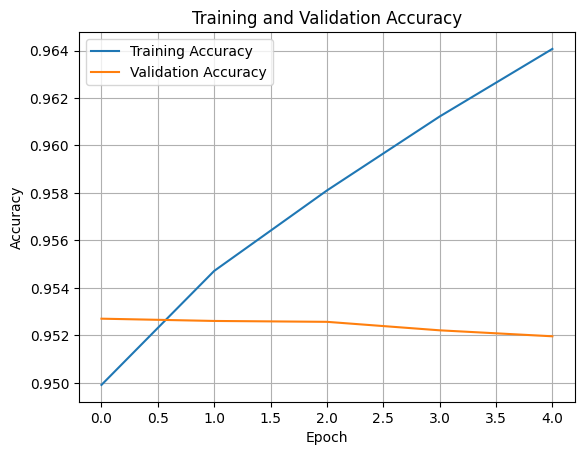

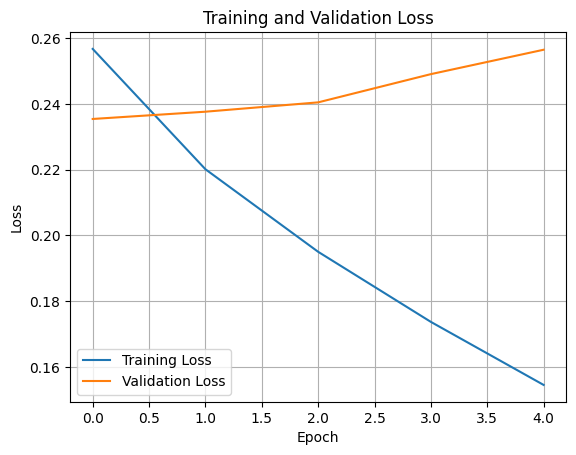

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [23]:
model.save_pretrained('question-generator-v1')

In [58]:
model = TFT5ForConditionalGeneration.from_pretrained("./question-generator-v1")
tokenizer = AutoTokenizer.from_pretrained("t5-small")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at ./question-generator-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [55]:
input = df_test.loc[0]['article']
input = f"Generate multiple choice question: The relationship between you and your psychologist can have a big impact on the outcomes of your therapy, so finding the right one for you is very important. Psychologists have a diverse range of skills, experience and expertise, and a psychologist who is a good fit for one person may not be the right fit for you. Doing your research and understanding what it is you need and expect from your relationship with your psychologist is a good starting point. When you seek help from a psychologist, you might see a psychologist with general registration, or one who also has a specific 'area of practice endorsement' (such as clinical psychology, health psychology or sport and exercise psychology). You can read more about these different types of psychologists below."
input

"Generate multiple choice question: The relationship between you and your psychologist can have a big impact on the outcomes of your therapy, so finding the right one for you is very important. Psychologists have a diverse range of skills, experience and expertise, and a psychologist who is a good fit for one person may not be the right fit for you. Doing your research and understanding what it is you need and expect from your relationship with your psychologist is a good starting point. When you seek help from a psychologist, you might see a psychologist with general registration, or one who also has a specific 'area of practice endorsement' (such as clinical psychology, health psychology or sport and exercise psychology). You can read more about these different types of psychologists below."

In [52]:
input_ids = tokenizer.encode(input, return_tensors="tf")

In [56]:
outputs = model.generate(input_ids, max_length=512)

decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Hasil keluaran model: {decoded_output}")

Hasil keluaran model: Q: What can we learn from the passage? A: (a) Nancy's body is a big river. (b) Nancy's body is a big river. (c) Nancy's body is a tree trunk. (d) Nancy's body is a tree trunk. Ans: 2
